# Turkish Lira Dataset

This project exploits the Turkish Lira Banknote Dataset available on Kaggle (https://www.kaggle.com/baltacifatih/turkish-lira-banknote-dataset) to implement from scratch an image classifier based on neural networks using Tensorflow.
The trained classifier must take an image as input and provide as output the corresponding predictions w.r.t. the 5, 10, 20, 500, 100, and 200 lira classes.

The dataset has already been divided into 5550 images for training and 450 for validation, for a grand total of 6000 images whose original shape is of 1280x720x3 (width, height and 3 RGB channels).

https://www.datacamp.com/community/tutorials/convolutional-neural-networks-python

Download the dataset and unzip it.

In [ ]:
#import kaggle
#kaggle.api.authenticate()
#kaggle.api.dataset_download_files('baltacifatih/turkish-lira-banknote-dataset', unzip=True)

In [1]:
import numpy as np
import pandas as pd
import pickle
import seaborn
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import pyplot

In [2]:
import tensorflow as tf
import os
from tensorflow import keras

print("Tensorflow version " + tf.__version__)

Tensorflow version 2.3.0


In [3]:
from skimage.io import imread
import glob
import re
import skimage
import cv2
from PIL import Image
%matplotlib inline

In [4]:
# Importing the Keras libraries and packages
from keras import backend as K
from keras.utils import to_categorical
from keras.layers import Dense, ZeroPadding2D, AveragePooling2D
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.applications import InceptionResNetV2
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Activation
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Data analysis

We import the data and analyze it.

The original dataset comprehends a training and a test sets of images, therefore no further train/test split will be employed. The training set contains 5550 images, while the test set contains the remaining 450 images.

In [5]:
raw_turkish=[]
with open("train.txt") as file:
    raw_turkish=file.readlines()

In [6]:
imageDir=''

images_turkish={}
turkish_labels, img_name=[], []
for i in range(0, len(raw_turkish)):
    #read each line as a string
    s=raw_turkish[i]
    s.rstrip("\n")
    #split each line by the slash:
    slashSplit=s.split("/")
    images={}
    for x in slashSplit:
        label=slashSplit[0]
        imageName=slashSplit[1].rstrip("\n")
        d={label:(imageDir+str(label)+'/'+imageName)}
        images.update(d)
    
    turkish_labels.append(np.int32(label))
    img_name.append(imageDir+str(label)+'/'+imageName)
    raw_turkish[i]=images

In [7]:
df_turkish = pd.DataFrame.from_dict({'image':img_name,
                                     'label':turkish_labels})

In [8]:
df_turkish = df_turkish.sample(frac=1)

In [9]:
df_turkish

,image,label
4724,200/eminus_200_1_0169.png,200
2331,20/20_2_0063.png,20
2658,20/flipped_20_1_0062.png,20
1025,10/eminus_10_1_0030.png,10
1629,10/saltAndPeppered_10_2_0034.png,10
...,...,...
4836,200/200_1_0079.png,200
1216,10/flipped_10_3_0064.png,10
1624,10/flipped_10_3_0054.png,10
3034,50/50_1_0022.png,50


In [10]:
raw_valid=[]
with open("validation.txt") as file_valid:
    raw_valid=file_valid.readlines()

In [11]:
images_valid={}
valid_labels, img_name_valid=[], []
for i in range(0, len(raw_valid)):
    #read each line as a string
    sValid=raw_valid[i]
    sValid.rstrip("\n")
    #split each line by the slash:
    slashSplitValid=sValid.split("/")
    imagesValid={}
    for x in slashSplitValid:
        labelValid=slashSplitValid[0]
        imageNameValid=slashSplitValid[1].rstrip("\n")
        dValid={labelValid:(imageDir+str(labelValid)+'/'+imageNameValid)}
        imagesValid.update(dValid)
    
    valid_labels.append(np.int32(labelValid))
    img_name_valid.append(imageDir+str(labelValid)+'/'+imageNameValid)
    raw_valid[i]=imagesValid

In [12]:
df_valid= pd.DataFrame.from_dict({'image':img_name_valid,
                                  'label':valid_labels})
df_valid = df_valid.sample(frac=1)

In [13]:
img=plt.imread(df_turkish.iloc[0]['image'])
height=img.shape[0]
width=img.shape[1]
channels=img.shape[2]
lab=df_turkish.iloc[0]['label']
print('image shape: width={}, height={}, channels={}'.format(width, width, channels))

image shape: width=1280, height=1280, channels=3


200


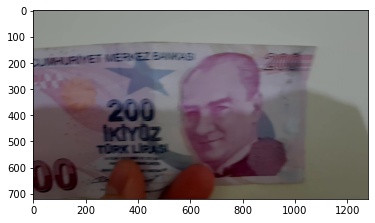

In [14]:
plt.imshow(img)
print(lab)

Let's analyze the distribution of the labels in order to check whether we need to adjust the class distribution of our dataset using for example oversampling or undersampling.

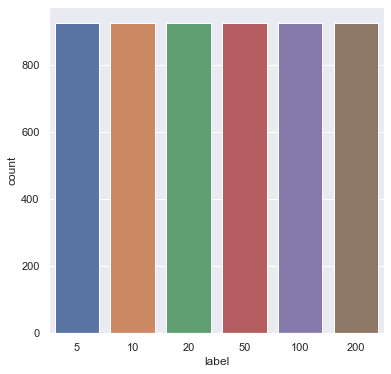

In [15]:
seaborn.set(rc={'figure.figsize':(6,6)})
seaborn.countplot(df_turkish['label'])

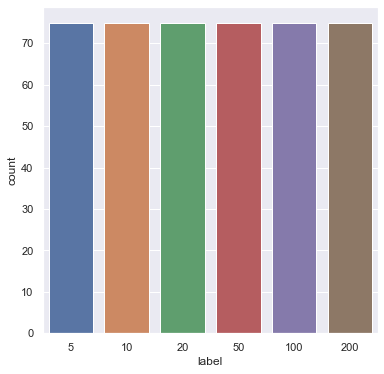

In [16]:
# Let's analyze the distribution of the labels
seaborn.set(rc={'figure.figsize':(6,6)})
seaborn.countplot(df_valid['label'])

As we can see the dataset is fully balanced therefore we do not need to implement any techniques of upsampling or downsampling.

# Preprocessing

In [17]:
from timeit import default_timer as timer

# get the starting time
startTime = timer()

# initialize the empty lists
x_turkish=[]
y_turkish1=[]
dim=64

# for loop to resize the images into 64x64 pictures
for row in df_turkish.iterrows():
    image = cv2.imread(row[1][0])
    img_array = Image.fromarray(image, 'RGB')
    img_resized = img_array.resize((dim,dim))
    x_turkish.append(np.array(img_resized))
    y_turkish1.append(row[1][1])
endTime = timer()

In [18]:
# get time taken to run the for loop
print("Time needed to perform the conversion is: {} minutes and {:.1f} seconds".format((endTime - startTime)//60, (endTime - startTime)%60))

Time needed to perform the conversion is: 5.0 minutes and 21.2 seconds


In [19]:
# get the starting time
startTimeValid = timer()

# initialize the empty lists
x_valid=[]
y_valid1=[]
dim=64

# for loop
for row in df_valid.iterrows():
    image= cv2.imread(row[1][0])
    img_array = Image.fromarray(image, 'RGB')
    img_resized = img_array.resize((dim,dim))
    x_valid.append(np.array(img_resized))
    y_valid1.append(np.array(row[1][1]))
endTimeValid = timer()

In [20]:
# get time taken to run the for loop
print("Time needed to perform the conversion of the validation set is: {} minutes and {:.1f} seconds".format((endTimeValid - startTimeValid)//60, (endTimeValid - startTimeValid)%60))

Time needed to perform the conversion of the validation set is: 0.0 minutes and 22.3 seconds


In [21]:
x_turkish=np.array(x_turkish)
y_turkish1=np.array(y_turkish1)
x_valid=np.array(x_valid)
y_valid1=np.array(y_valid1)

In [22]:
x_turkish.shape

(5550, 64, 64, 3)

In [23]:
y_turkish=[]
for i in y_turkish1:
    if (i==5):
        y_turkish.append([0])
    elif (i==10):
        y_turkish.append([1])
    elif (i==20):
        y_turkish.append([2])
    elif (i==50):
        y_turkish.append([3])
    elif (i==100):
        y_turkish.append([4])
    elif (i==200):
        y_turkish.append([5])

In [24]:
y_valid=[]
for i in y_valid1:
    if (i==5):
        y_valid.append([0])
    elif (i==10):
        y_valid.append([1])
    elif (i==20):
        y_valid.append([2])
    elif (i==50):
        y_valid.append([3])
    elif (i==100):
        y_valid.append([4])
    elif (i==200):
        y_valid.append([5])

In [25]:
y_turkish=np.array(y_turkish)
y_valid=np.array(y_valid)

In [26]:
x_train, x_test, y_train, y_test = train_test_split(x_turkish, y_turkish, test_size=0.2, random_state=42)

In [27]:
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(4440, 64, 64, 3) (1110, 64, 64, 3) (4440, 1) (1110, 1)


In [28]:
y_train = np.reshape(y_train, (y_train.shape[0], 1))
y_test = np.reshape(y_test, (y_test.shape[0], 1))
y_valid = np.reshape(y_valid, (y_valid.shape[0], 1))

In [29]:
print(y_train.shape)
print(y_test.shape)
print(y_valid.shape)

(4440, 1)
(1110, 1)
(450, 1)


2


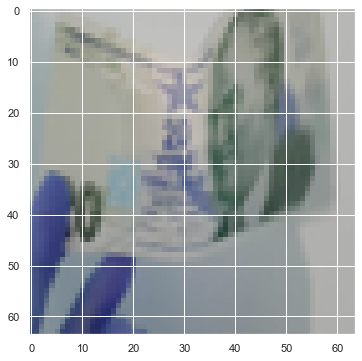

In [30]:
plt.imshow(x_valid[0])
print(y_valid[0][0])

3

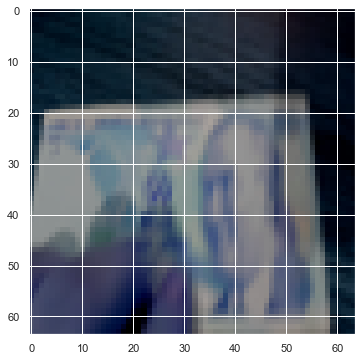

In [31]:
plt.imshow(x_train[0])
y_train[0][0]

5

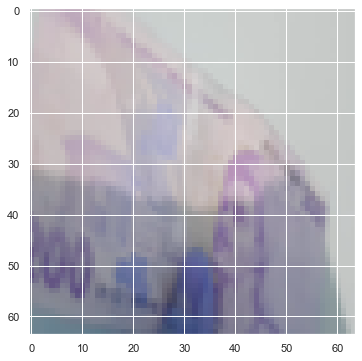

In [32]:
plt.imshow(x_test[0])
y_test[0][0]

# Grayscale conversion of the images

We will use the tf.image.rgb_to_grayscale function, which converts more efficiently one or more images from RGB to Grayscale.

In [33]:
x_train_gray = tf.image.rgb_to_grayscale(x_train)
x_valid_gray = tf.image.rgb_to_grayscale(x_valid)
x_test_gray = tf.image.rgb_to_grayscale(x_test)

In [34]:
print(x_train_gray.shape, x_test_gray.shape, x_valid_gray.shape)

(4440, 64, 64, 1) (1110, 64, 64, 1) (450, 64, 64, 1)


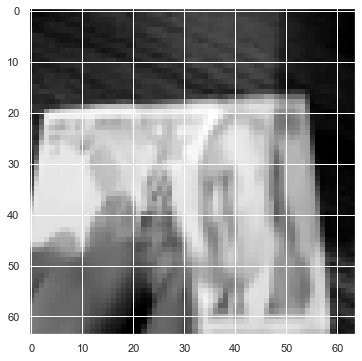

In [35]:
dim = 64
plt.imshow(tf.reshape(x_train_gray[0],[dim, dim]), cmap = "gray")

# RGB color model

It seems appropriate to briefly introduce the RGB color model. A color model is an abstract mathematical model describing the way colors can be represented as tuples of numbers, typically as three (as in our case) or four values or color components. The RGB model is an additive color model since the perceived color can be predicted by summing the numeric representations of the component colors which in this model are Red, Green and Blue.

We need to:
- convert the labels to one hot encoding format;
- rescale pixel intensity values in the interval [0,1]
https://machinelearningmastery.com/how-to-manually-scale-image-pixel-data-for-deep-learning/

In [36]:
# RGB scale version
train_set_size=x_train.shape[0]
valid_set_size=x_valid.shape[0]
test_set_size=x_test.shape[0]
img_dim=np.int32(64)
dim=64
rgb=3
max_value=255.0

# one hot encoding
y_train_hot = to_categorical(y_train, 6)
y_valid_hot = to_categorical(y_valid, 6)
y_test_hot = to_categorical(y_test, 6)

# rescale in [0,1]
x_train = tf.cast(x_train, tf.float32) / max_value
x_valid = tf.cast(x_valid, tf.float32) / max_value
x_test = tf.cast(x_test, tf.float32) / max_value

In [37]:
# RGB flatted images
# flatten the images
x_train_flat = tf.reshape(x_train, [train_set_size, img_dim * img_dim * 3])
x_test_flat = tf.reshape(x_test, [test_set_size, img_dim * img_dim * 3])
x_valid_flat = tf.reshape(x_valid, [valid_set_size, img_dim * img_dim * 3])

# rescale in [0,1]
x_train_flat = tf.cast(x_train_flat, tf.float32) / max_value
x_valid_flat = tf.cast(x_valid_flat, tf.float32) / max_value
x_test_flat = tf.cast(x_test_flat, tf.float32) / max_value

In [38]:
x_train.shape

TensorShape([4440, 64, 64, 3])

In [39]:
# Gray scale version
train_gray_size=x_train_gray.shape[0]
valid_gray_size=x_valid_gray.shape[0]
test_gray_size=x_test_gray.shape[0]
img_dim=np.int32(64)
max_value=np.float32(255.0)

# rescale the flatted images in [0,1]
x_train_gray = tf.cast(x_train_gray, tf.float32) / max_value
x_valid_gray = tf.cast(x_valid_gray, tf.float32) / max_value
x_test_gray = tf.cast(x_test_gray, tf.float32) / max_value

In [40]:
# Grayscale flatted images
# flatten the images
x_train_gray_flat = tf.reshape(x_train_gray, [train_gray_size, img_dim * img_dim])
x_test_gray_flat = tf.reshape(x_test_gray, [test_gray_size, img_dim * img_dim])
x_valid_gray_flat = tf.reshape(x_valid_gray, [valid_gray_size, img_dim * img_dim])

# rescale the flatted images in [0,1]
x_train_gray_flat = tf.cast(x_train_gray_flat, tf.float32) / max_value
x_valid_gray_flat = tf.cast(x_valid_gray_flat, tf.float32) / max_value
x_test_gray_flat = tf.cast(x_test_gray_flat, tf.float32) / max_value

In [41]:
print(x_train_gray_flat.shape, y_train_hot.shape, x_test_gray_flat.shape, y_test_hot.shape)

(4440, 4096) (4440, 6) (1110, 4096) (1110, 6)


# Feed-forward neural networks

To build an image classifier we proceed as follows:
- convert RGB images in grayscale,
- flatten the images;
- build a feed-forward neural network;
- tune the network to improve the accuracy.

We also modify the visualization of the labels of the test set.

In [42]:
y_test_orig=[]
for elem in y_test:
    y_test_orig.append(elem[0])

We then test a one layer feed-forward neural network.

In [43]:
batch_size=64
epochs=10

In [44]:
model_one_layer = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(64*64,)),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])

model_one_layer.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])
model_one_layer.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 4096)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               409700    
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 606       
Total params: 410,306
Trainable params: 410,306
Non-trainable params: 0
_________________________________________________________________


In [45]:
history_one_layer= model_one_layer.fit(x_train_gray_flat,
                                       y_train_hot,
                                       batch_size=batch_size,
                                       epochs=epochs,
                                       validation_data=(x_valid_gray_flat, y_valid_hot),
                                       validation_steps=1)       

Epoch 1/10
70/70 [==============================] - 1s 10ms/step - loss: 0.4494 - accuracy: 0.1926 - val_loss: 0.4459 - val_accuracy: 0.3281
Epoch 2/10
70/70 [==============================] - 0s 6ms/step - loss: 0.4439 - accuracy: 0.2775 - val_loss: 0.4422 - val_accuracy: 0.3594
Epoch 3/10
70/70 [==============================] - 0s 5ms/step - loss: 0.4369 - accuracy: 0.2764 - val_loss: 0.4388 - val_accuracy: 0.2812
Epoch 4/10
70/70 [==============================] - 0s 6ms/step - loss: 0.4313 - accuracy: 0.2959 - val_loss: 0.4335 - val_accuracy: 0.3438
Epoch 5/10
70/70 [==============================] - 0s 6ms/step - loss: 0.4278 - accuracy: 0.2968 - val_loss: 0.4285 - val_accuracy: 0.3125
Epoch 6/10
70/70 [==============================] - 0s 6ms/step - loss: 0.4248 - accuracy: 0.3036 - val_loss: 0.4251 - val_accuracy: 0.3906
Epoch 7/10
70/70 [==============================] - 0s 6ms/step - loss: 0.4226 - accuracy: 0.3214 - val_loss: 0.4266 - val_accuracy: 0.3438
Epoch 8/10
70/70 [=

In [46]:
model_predict_one_layer = model_one_layer.evaluate(x_test_gray_flat, y_test_hot, batch_size=100)

12/12 [==============================] - 0s 2ms/step - loss: 0.4141 - accuracy: 0.3441


In [47]:
pred_labels_one_layer=model_one_layer.predict_classes(x_test_gray_flat)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [48]:
y_pred_one_layer=[]
for elem in pred_labels_one_layer:
    y_pred_one_layer.append(elem)

In [49]:
df_one_layer=pd.DataFrame({'Original labels':y_test_orig,
                           'Predicted labels':y_pred_one_layer})
df_one_layer

,Original labels,Predicted labels
0,5,5
1,5,5
2,5,3
3,4,5
4,0,2
...,...,...
1105,0,0
1106,3,3
1107,2,5
1108,2,2


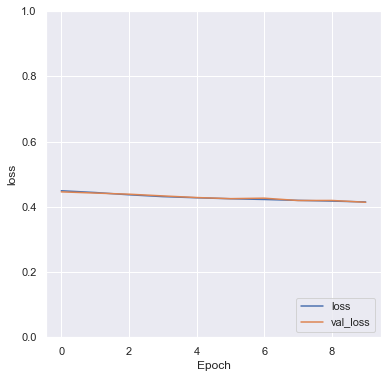

In [50]:
plt.plot(history_one_layer.history['loss'], label='loss')
plt.plot(history_one_layer.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.ylim([0.0, 1.0])
plt.legend(loc='lower right')

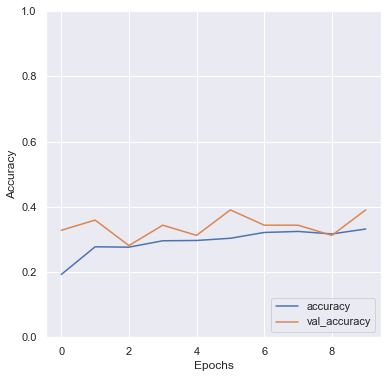

In [51]:
plt.plot(history_one_layer.history['accuracy'], label='accuracy')
plt.plot(history_one_layer.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim([0.0, 1.0])
plt.legend(loc='lower right')

Let's try adding another layer: Two layer network.

In [52]:
model_two_layer = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(64*64,)),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])

model_two_layer.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])
model_two_layer.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               409700    
_________________________________________________________________
dense_3 (Dense)              (None, 64)                6464      
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 390       
Total params: 416,554
Trainable params: 416,554
Non-trainable params: 0
_________________________________________________________________


In [53]:
history_two_layer= model_two_layer.fit(x_train_gray_flat,
                                       y_train_hot,
                                       batch_size=batch_size,
                                       epochs=epochs,
                                       validation_data=(x_valid_gray_flat, y_valid_hot),
                                       validation_steps=1)      

Epoch 1/10
70/70 [==============================] - 1s 8ms/step - loss: 0.4494 - accuracy: 0.2081 - val_loss: 0.4474 - val_accuracy: 0.3125
Epoch 2/10
70/70 [==============================] - 0s 6ms/step - loss: 0.4409 - accuracy: 0.2586 - val_loss: 0.4339 - val_accuracy: 0.2500
Epoch 3/10
70/70 [==============================] - 0s 6ms/step - loss: 0.4329 - accuracy: 0.2653 - val_loss: 0.4310 - val_accuracy: 0.3281
Epoch 4/10
70/70 [==============================] - 0s 6ms/step - loss: 0.4280 - accuracy: 0.2944 - val_loss: 0.4283 - val_accuracy: 0.3281
Epoch 5/10
70/70 [==============================] - 0s 6ms/step - loss: 0.4236 - accuracy: 0.3151 - val_loss: 0.4243 - val_accuracy: 0.3438
Epoch 6/10
70/70 [==============================] - 0s 6ms/step - loss: 0.4191 - accuracy: 0.3300 - val_loss: 0.4183 - val_accuracy: 0.3594
Epoch 7/10
70/70 [==============================] - 0s 6ms/step - loss: 0.4155 - accuracy: 0.3331 - val_loss: 0.4137 - val_accuracy: 0.3281
Epoch 8/10
70/70 [==

There is a slight improvement in accuracy.

In [54]:
model_predict_two_layer = model_two_layer.evaluate(x_test_gray_flat,
                                                   y_test_hot,
                                                   batch_size=100)

12/12 [==============================] - 0s 2ms/step - loss: 0.4043 - accuracy: 0.3865


In [55]:
pred_labels_two_layer=model_two_layer.predict_classes(x_test_gray_flat)

In [56]:
y_pred_two_layer=[]
for elem in pred_labels_two_layer:
    y_pred_two_layer.append(elem)

In [57]:
df_two_layer=pd.DataFrame({'Original labels':y_test_orig,
                           'Predicted labels':y_pred_two_layer})
df_two_layer

,Original labels,Predicted labels
0,5,5
1,5,5
2,5,2
3,4,4
4,0,0
...,...,...
1105,0,0
1106,3,3
1107,2,4
1108,2,0


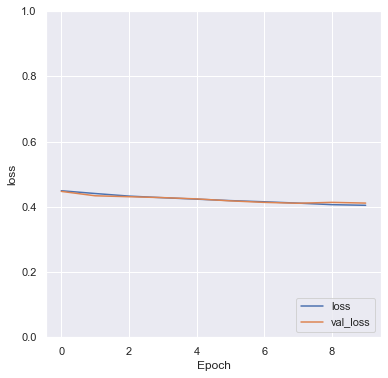

In [58]:
plt.plot(history_two_layer.history['loss'], label='loss')
plt.plot(history_two_layer.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.ylim([0.0, 1.0])
plt.legend(loc='lower right')

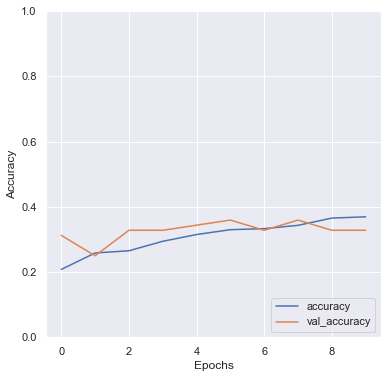

In [59]:
plt.plot(history_two_layer.history['accuracy'], label='accuracy')
plt.plot(history_two_layer.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim([0.0, 1.0])
plt.legend(loc='lower right')

Adding dropout since there seems to be overfitting

In [60]:
ff_two_drop = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(64*64,)),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(6, activation='softmax')
])

ff_two_drop.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

ff_two_drop.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 100)               409700    
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                6464      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 6)                 390       
Total params: 416,554
Trainable params: 416,554
Non-trainable params: 0
________________________________________________

In [61]:
history_ff_two_drop= ff_two_drop.fit(x_train_gray_flat,
                                       y_train_hot,
                                       batch_size=batch_size,
                                       epochs=20,
                                       validation_data=(x_valid_gray_flat, y_valid_hot),
                                       validation_steps=1)      

Epoch 1/20
70/70 [==============================] - 1s 9ms/step - loss: 0.4495 - accuracy: 0.2043 - val_loss: 0.4481 - val_accuracy: 0.2344
Epoch 2/20
70/70 [==============================] - 0s 6ms/step - loss: 0.4434 - accuracy: 0.2430 - val_loss: 0.4414 - val_accuracy: 0.2656
Epoch 3/20
70/70 [==============================] - 0s 6ms/step - loss: 0.4369 - accuracy: 0.2541 - val_loss: 0.4354 - val_accuracy: 0.2812
Epoch 4/20
70/70 [==============================] - 0s 6ms/step - loss: 0.4328 - accuracy: 0.2745 - val_loss: 0.4323 - val_accuracy: 0.2656
Epoch 5/20
70/70 [==============================] - 0s 5ms/step - loss: 0.4303 - accuracy: 0.2885 - val_loss: 0.4277 - val_accuracy: 0.3750
Epoch 6/20
70/70 [==============================] - 0s 6ms/step - loss: 0.4276 - accuracy: 0.3081 - val_loss: 0.4252 - val_accuracy: 0.3438
Epoch 7/20
70/70 [==============================] - 0s 6ms/step - loss: 0.4250 - accuracy: 0.3113 - val_loss: 0.4212 - val_accuracy: 0.4062
Epoch 8/20
70/70 [==

In [62]:
model_predict_ff_two_drop = ff_two_drop.evaluate(x_test_gray_flat,
                                                   y_test_hot,
                                                   batch_size=100)


12/12 [==============================] - 0s 2ms/step - loss: 0.3697 - accuracy: 0.4514


In [63]:
pred_labels_ff_two_drop=ff_two_drop.predict_classes(x_test_gray_flat)

In [64]:
y_pred_ff_two_drop=[]
for elem in pred_labels_ff_two_drop:
    y_pred_ff_two_drop.append(elem)

In [65]:
df_ff_two_drop=pd.DataFrame({'Original labels':y_test_orig,
                           'Predicted labels':y_pred_ff_two_drop})
df_ff_two_drop

,Original labels,Predicted labels
0,5,5
1,5,5
2,5,1
3,4,1
4,0,2
...,...,...
1105,0,0
1106,3,3
1107,2,1
1108,2,0


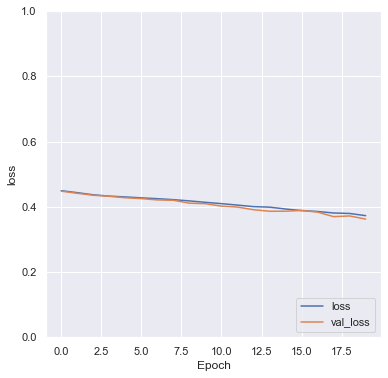

In [66]:
plt.plot(history_ff_two_drop.history['loss'], label='loss')
plt.plot(history_ff_two_drop.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.ylim([0.0, 1.0])
plt.legend(loc='lower right')

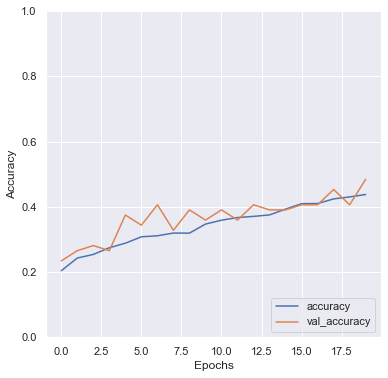

In [67]:
plt.plot(history_ff_two_drop.history['accuracy'], label='accuracy')
plt.plot(history_ff_two_drop.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim([0.0, 1.0])
plt.legend(loc='lower right')

Let's try adding a third layer: Three layer network

In [69]:
model_three_layer = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(4096,)),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(6, activation='softmax')
])

model_three_layer.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])
model_three_layer.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 100)               409700    
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 64)                6464      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 16)                1040      
_________________________________________________________________
dropout_4 (Dropout)          (None, 16)               

In [70]:
history_three_layer= model_three_layer.fit(x_train_gray_flat,
                                           y_train_hot,
                                           batch_size=batch_size,
                                           epochs=epochs,
                                           validation_data=(x_valid_gray_flat, y_valid_hot),
                                           validation_steps=1)       

Epoch 1/10
70/70 [==============================] - 1s 9ms/step - loss: 0.4507 - accuracy: 0.1705 - val_loss: 0.4510 - val_accuracy: 0.1094
Epoch 2/10
70/70 [==============================] - 0s 6ms/step - loss: 0.4501 - accuracy: 0.1764 - val_loss: 0.4503 - val_accuracy: 0.1094
Epoch 3/10
70/70 [==============================] - 0s 7ms/step - loss: 0.4473 - accuracy: 0.2097 - val_loss: 0.4451 - val_accuracy: 0.2344
Epoch 4/10
70/70 [==============================] - 1s 7ms/step - loss: 0.4398 - accuracy: 0.2563 - val_loss: 0.4383 - val_accuracy: 0.2188
Epoch 5/10
70/70 [==============================] - 0s 7ms/step - loss: 0.4354 - accuracy: 0.2664 - val_loss: 0.4345 - val_accuracy: 0.3125
Epoch 6/10
70/70 [==============================] - 0s 7ms/step - loss: 0.4311 - accuracy: 0.2860 - val_loss: 0.4265 - val_accuracy: 0.3438
Epoch 7/10
70/70 [==============================] - 0s 7ms/step - loss: 0.4287 - accuracy: 0.2903 - val_loss: 0.4193 - val_accuracy: 0.3438
Epoch 8/10
70/70 [==

We get back to the performances of the one layer network.

In [71]:
model_predict_three_layer = model_three_layer.evaluate(x_test_gray_flat,
                                                       y_test_hot,
                                                       batch_size=100)

12/12 [==============================] - 0s 2ms/step - loss: 0.4061 - accuracy: 0.3640


In [72]:
pred_labels_three_layer = model_three_layer.predict_classes(x_test_gray_flat)

In [73]:
y_pred_three_layer=[]
for elem in pred_labels_three_layer:
    y_pred_three_layer.append(elem)

In [74]:
df_three_layer=pd.DataFrame({'Original labels':y_test_orig,
                             'Predicted labels':y_pred_three_layer})
df_three_layer

,Original labels,Predicted labels
0,5,5
1,5,5
2,5,3
3,4,5
4,0,2
...,...,...
1105,0,0
1106,3,3
1107,2,5
1108,2,3


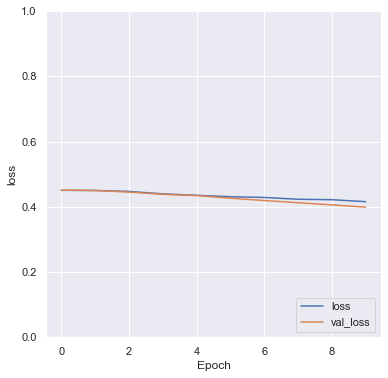

In [75]:
plt.plot(history_three_layer.history['loss'], label='loss')
plt.plot(history_three_layer.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.ylim([0.0, 1.0])
plt.legend(loc='lower right')

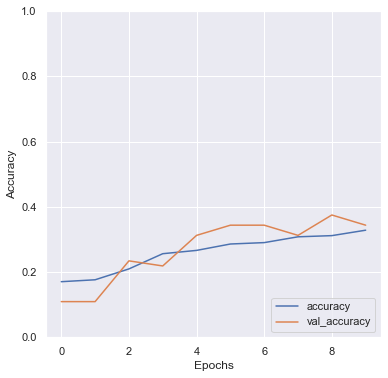

In [76]:
plt.plot(history_three_layer.history['accuracy'], label='accuracy')
plt.plot(history_three_layer.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim([0.0, 1.0])
plt.legend(loc='lower right')

Learning rate

In [77]:
import math
def lr_decay(epoch):
    return 0.01 * math.pow(0.6, epoch)

# lr schedule callback
lr_decay_callback = tf.keras.callbacks.LearningRateScheduler(lr_decay, verbose=True)

Two layer model

In [78]:
model_two_layer_lr = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(64*64,)),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(6, activation='softmax')
])

model_two_layer_lr.compile(loss = 'binary_crossentropy',
              optimizer = tf.keras.optimizers.Adam(lr=0.01),
              metrics = ['accuracy'])
model_two_layer_lr.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 100)               409700    
_________________________________________________________________
dropout_5 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 64)                6464      
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 6)                 390       
Total params: 416,554
Trainable params: 416,554
Non-trainable params: 0
________________________________________________

In [79]:
history_two_layer_lr= model_two_layer_lr.fit(x_train_gray_flat,
                                       y_train_hot,
                                       batch_size=batch_size,
                                       epochs=20,
                                       validation_data=(x_valid_gray_flat, y_valid_hot),
                                       validation_steps=1,
                                       callbacks=[lr_decay_callback])      


Epoch 00001: LearningRateScheduler reducing learning rate to 0.01.
Epoch 1/20
70/70 [==============================] - 1s 9ms/step - loss: 0.4478 - accuracy: 0.2128 - val_loss: 0.4391 - val_accuracy: 0.2812

Epoch 00002: LearningRateScheduler reducing learning rate to 0.006.
Epoch 2/20
70/70 [==============================] - 0s 6ms/step - loss: 0.4355 - accuracy: 0.2574 - val_loss: 0.4360 - val_accuracy: 0.2812

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0036.
Epoch 3/20
70/70 [==============================] - 0s 7ms/step - loss: 0.4309 - accuracy: 0.2745 - val_loss: 0.4286 - val_accuracy: 0.3594

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0021599999999999996.
Epoch 4/20
70/70 [==============================] - 0s 7ms/step - loss: 0.4283 - accuracy: 0.3014 - val_loss: 0.4282 - val_accuracy: 0.3281

Epoch 00005: LearningRateScheduler reducing learning rate to 0.001296.
Epoch 5/20
70/70 [==============================] - 0s 7ms/step - loss: 0.42

In [80]:
model_predict_two_layer_lr = model_two_layer_lr.evaluate(x_test_gray_flat,
                                                       y_test_hot,
                                                       batch_size=100)

12/12 [==============================] - 0s 2ms/step - loss: 0.4150 - accuracy: 0.3423


In [81]:
pred_labels_two_layer_lr = model_two_layer_lr.predict_classes(x_test_gray_flat)

In [82]:
y_pred_two_layer_lr=[]
for elem in pred_labels_two_layer_lr:
    y_pred_two_layer_lr.append(elem)

In [83]:
df_two_layer_lr=pd.DataFrame({'Original labels':y_test_orig,
                             'Predicted labels':y_pred_two_layer_lr})
df_two_layer_lr

,Original labels,Predicted labels
0,5,5
1,5,5
2,5,3
3,4,5
4,0,2
...,...,...
1105,0,0
1106,3,3
1107,2,5
1108,2,0


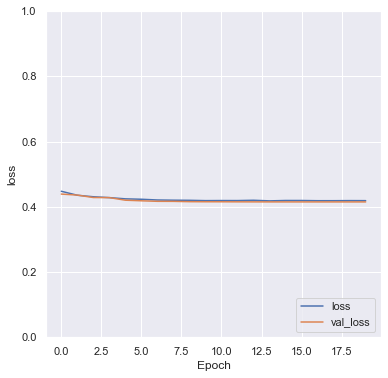

In [84]:
plt.plot(history_two_layer_lr.history['loss'], label='loss')
plt.plot(history_two_layer_lr.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.ylim([0.0, 1.0])
plt.legend(loc='lower right')

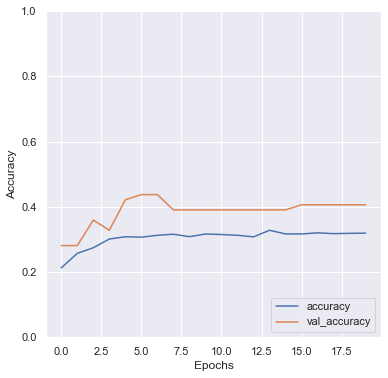

In [85]:
plt.plot(history_two_layer_lr.history['accuracy'], label='accuracy')
plt.plot(history_two_layer_lr.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim([0.0, 1.0])
plt.legend(loc='lower right')

Three layer network

In [86]:
model_three_layer_lr = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(4096,)),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(6, activation='softmax')
])

model_three_layer_lr.compile(loss = 'binary_crossentropy',
              optimizer = tf.keras.optimizers.Adam(lr=0.01),
              metrics = ['accuracy'])

model_three_layer_lr.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_6 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_19 (Dense)             (None, 100)               409700    
_________________________________________________________________
dropout_7 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 64)                6464      
_________________________________________________________________
dropout_8 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 16)                1040      
_________________________________________________________________
dropout_9 (Dropout)          (None, 16)               

In [87]:
history_three_layer_lr= model_three_layer_lr.fit(x_train_gray_flat,
                                       y_train_hot,
                                       batch_size=batch_size,
                                       epochs=epochs,
                                       validation_data=(x_valid_gray_flat, y_valid_hot),
                                       validation_steps=1,
                                       callbacks=[lr_decay_callback])      


Epoch 00001: LearningRateScheduler reducing learning rate to 0.01.
Epoch 1/10
70/70 [==============================] - 1s 9ms/step - loss: 0.4476 - accuracy: 0.1937 - val_loss: 0.4340 - val_accuracy: 0.2344

Epoch 00002: LearningRateScheduler reducing learning rate to 0.006.
Epoch 2/10
70/70 [==============================] - 0s 6ms/step - loss: 0.4378 - accuracy: 0.2428 - val_loss: 0.4308 - val_accuracy: 0.3281

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0036.
Epoch 3/10
70/70 [==============================] - 0s 7ms/step - loss: 0.4344 - accuracy: 0.2491 - val_loss: 0.4285 - val_accuracy: 0.3125

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0021599999999999996.
Epoch 4/10
70/70 [==============================] - 1s 7ms/step - loss: 0.4292 - accuracy: 0.2694 - val_loss: 0.4264 - val_accuracy: 0.3125

Epoch 00005: LearningRateScheduler reducing learning rate to 0.001296.
Epoch 5/10
70/70 [==============================] - 0s 7ms/step - loss: 0.42

In [88]:
model_predict_three_layer_lr = model_three_layer_lr.evaluate(x_test_gray_flat,
                                                       y_test_hot,
                                                       batch_size=100)

pred_labels_three_layer_lr = model_three_layer_lr.predict_classes(x_test_gray_flat)

12/12 [==============================] - 0s 2ms/step - loss: 0.4181 - accuracy: 0.3063


In [89]:
y_pred_three_layer_lr=[]
for elem in pred_labels_three_layer_lr:
    y_pred_three_layer_lr.append(elem)

In [90]:
df_three_layer_lr=pd.DataFrame({'Original labels':y_test_orig,
                             'Predicted labels':y_pred_three_layer_lr})
df_three_layer_lr

,Original labels,Predicted labels
0,5,5
1,5,5
2,5,3
3,4,5
4,0,3
...,...,...
1105,0,3
1106,3,3
1107,2,4
1108,2,3


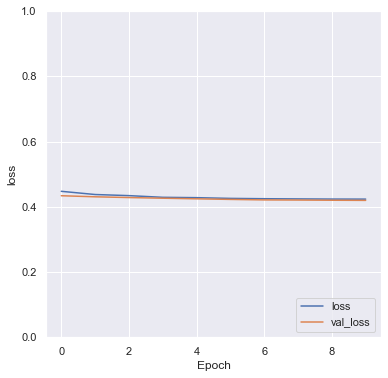

In [91]:
plt.plot(history_three_layer_lr.history['loss'], label='loss')
plt.plot(history_three_layer_lr.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.ylim([0.0, 1.0])
plt.legend(loc='lower right')

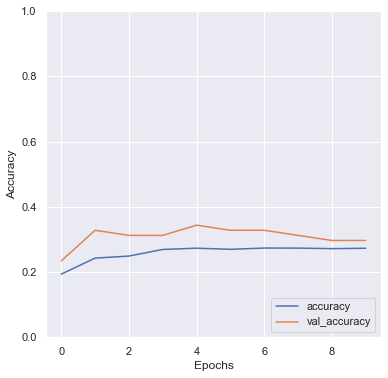

In [92]:
plt.plot(history_three_layer_lr.history['accuracy'], label='accuracy')
plt.plot(history_three_layer_lr.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim([0.0, 1.0])
plt.legend(loc='lower right')

# CNN with RGB images

In order to avoid the loss of shape information especially important with image classification we try with convolutional neural network.

One VGG block

In [93]:
model_one_vgg = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), padding = "same", activation='relu', input_shape = (64, 64, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), padding = "same", activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dense(6, activation = 'softmax')
])

model_one_vgg.compile(optimizer = "adam",
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

model_one_vgg.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 64)        1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        18464     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_23 (Dense)             (None, 64)                2097216   
_________________________________________________________________
dense_24 (Dense)             (None, 6)                 390       
Total params: 2,117,862
Trainable params: 2,117,862
Non-trainable params: 0
____________________________________________

In [94]:
train_one_vgg = model_one_vgg.fit(x_train,
                                  y_train_hot,
                                  epochs=epochs,
                                  batch_size=batch_size,
                                  validation_data=(x_valid, y_valid_hot),
                                  validation_steps=1)

test_one_vgg = model_one_vgg.evaluate(x_test,
                                      y_test_hot,
                                      verbose=0)       

Epoch 1/10
70/70 [==============================] - 41s 587ms/step - loss: 0.4070 - accuracy: 0.3750 - val_loss: 0.2609 - val_accuracy: 0.6562
Epoch 2/10
70/70 [==============================] - 42s 595ms/step - loss: 0.1959 - accuracy: 0.7577 - val_loss: 0.1253 - val_accuracy: 0.8750
Epoch 3/10
70/70 [==============================] - 41s 590ms/step - loss: 0.1112 - accuracy: 0.8730 - val_loss: 0.1789 - val_accuracy: 0.8125
Epoch 4/10
70/70 [==============================] - 41s 591ms/step - loss: 0.0766 - accuracy: 0.9173 - val_loss: 0.0874 - val_accuracy: 0.8750
Epoch 5/10
70/70 [==============================] - 42s 593ms/step - loss: 0.0388 - accuracy: 0.9619 - val_loss: 0.0311 - val_accuracy: 0.9688
Epoch 6/10
70/70 [==============================] - 42s 593ms/step - loss: 0.0202 - accuracy: 0.9818 - val_loss: 0.0216 - val_accuracy: 0.9844
Epoch 7/10
70/70 [==============================] - 41s 593ms/step - loss: 0.0130 - accuracy: 0.9896 - val_loss: 0.0292 - val_accuracy: 0.9688

In [95]:
pred_labels_one_vgg = model_one_vgg.predict_classes(x_test)

In [96]:
y_pred_one_vgg=[]
for elem in pred_labels_one_vgg:
    y_pred_one_vgg.append(elem)

In [97]:
df_one_vgg=pd.DataFrame({'Original labels':y_test_orig,
                         'Predicted labels':y_pred_one_vgg})
df_one_vgg

,Original labels,Predicted labels
0,5,5
1,5,5
2,5,5
3,4,4
4,0,0
...,...,...
1105,0,0
1106,3,3
1107,2,2
1108,2,2


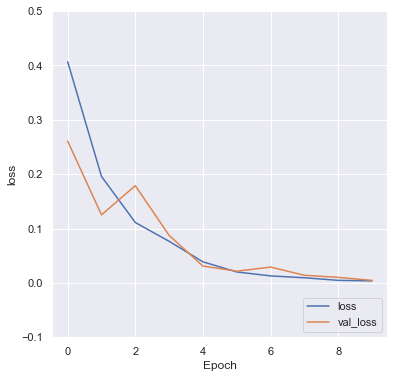

In [98]:
plt.plot(train_one_vgg.history['loss'], label='loss')
plt.plot(train_one_vgg.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.ylim([-0.1, 0.5])
plt.legend(loc='lower right')

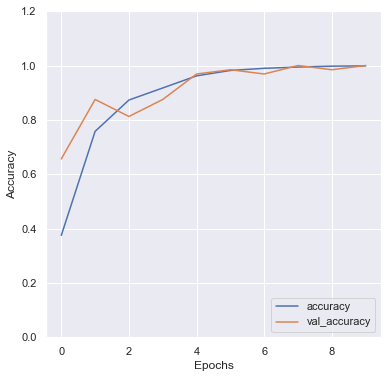

In [99]:
plt.plot(train_one_vgg.history['accuracy'], label='accuracy')
plt.plot(train_one_vgg.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim([0.0, 1.2])
plt.legend(loc='lower right')

VGG with two layers

In [187]:
model_two_vgg = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), padding = "same", activation='relu', input_shape = (64, 64, 3)),
    tf.keras.layers.Conv2D(64, (3, 3), padding = "same", activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), padding = "same", activation='relu'),
    tf.keras.layers.Conv2D(128, (3, 3), padding = "same", activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dense(6, activation = 'softmax')
])

model_two_vgg.compile(optimizer = "adam",
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

model_two_vgg.summary()

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_62 (Conv2D)           (None, 64, 64, 64)        1792      
_________________________________________________________________
conv2d_63 (Conv2D)           (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_64 (Conv2D)           (None, 32, 32, 128)       73856     
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 32, 32, 128)       147584    
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 16, 16, 128)       0         
_________________________________________________________________
flatten_25 (Flatten)         (None, 32768)           

In [188]:
train_two_vgg = model_two_vgg.fit(x_train,
                                  y_train_hot,
                                  epochs=epochs,
                                  batch_size=batch_size,
                                  validation_data=(x_valid, y_valid_hot),
                                  validation_steps=1)

test_two_vgg = model_two_vgg.evaluate(x_test,
                                      y_test_hot,
                                      verbose=0)       

Epoch 1/10
70/70 [==============================] - 78s 1s/step - loss: 0.3430 - accuracy: 0.4788 - val_loss: 0.2352 - val_accuracy: 0.7344
Epoch 2/10
70/70 [==============================] - 81s 1s/step - loss: 0.1369 - accuracy: 0.8315 - val_loss: 0.0715 - val_accuracy: 0.9219
Epoch 3/10
70/70 [==============================] - 86s 1s/step - loss: 0.0683 - accuracy: 0.9250 - val_loss: 0.0344 - val_accuracy: 0.9688
Epoch 4/10
70/70 [==============================] - 81s 1s/step - loss: 0.0305 - accuracy: 0.9716 - val_loss: 0.0307 - val_accuracy: 0.9531
Epoch 5/10
70/70 [==============================] - 79s 1s/step - loss: 0.0311 - accuracy: 0.9671 - val_loss: 0.0076 - val_accuracy: 1.0000
Epoch 6/10
70/70 [==============================] - 81s 1s/step - loss: 0.0156 - accuracy: 0.9858 - val_loss: 0.0256 - val_accuracy: 0.9844
Epoch 7/10
70/70 [==============================] - 79s 1s/step - loss: 0.0132 - accuracy: 0.9876 - val_loss: 0.3052 - val_accuracy: 0.7344
Epoch 8/10
70/70 [==

In [102]:
pred_labels_two_vgg = model_two_vgg.predict_classes(x_test)

In [103]:
y_pred_two_vgg=[]
for elem in pred_labels_two_vgg:
    y_pred_two_vgg.append(elem)

In [104]:
df_two_vgg=pd.DataFrame({'Original labels':y_test_orig,
                         'Predicted labels':y_pred_two_vgg})
df_two_vgg

,Original labels,Predicted labels
0,5,5
1,5,5
2,5,5
3,4,4
4,0,0
...,...,...
1105,0,0
1106,3,3
1107,2,2
1108,2,2


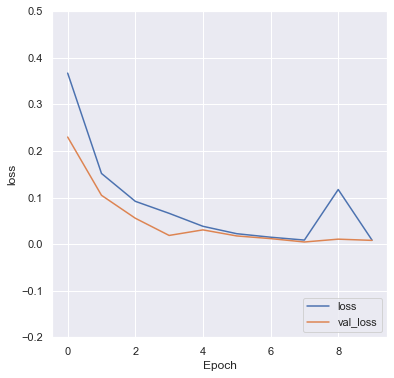

In [105]:
plt.plot(train_two_vgg.history['loss'], label='loss')
plt.plot(train_two_vgg.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.ylim([-0.2, 0.5])
plt.legend(loc='lower right')

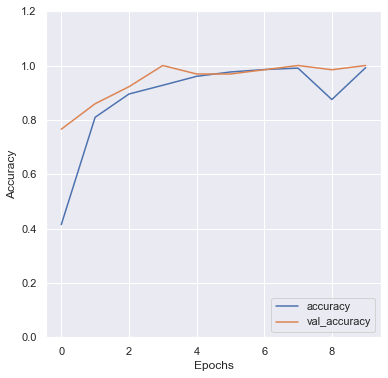

In [106]:
plt.plot(train_two_vgg.history['accuracy'], label='accuracy')
plt.plot(train_two_vgg.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim([0.0, 1.2])
plt.legend(loc='lower right')

The addition of an adaptive learning rate doesn't seem to bring any improvement in the performance. In the previous 2-layers model dropout will be added although there doesn't seem to be any sign of overfitting.

In [107]:
model_two_vgg_drop = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), padding = "same", activation='relu', input_shape = (64, 64, 3)),
    tf.keras.layers.Conv2D(64, (3, 3), padding = "same", activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(128, (3, 3), padding = "same", activation='relu'),
    tf.keras.layers.Conv2D(128, (3, 3), padding = "same", activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(6, activation = 'softmax')
])

model_two_vgg_drop.compile(optimizer = "adam",
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

model_two_vgg_drop.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 64, 64, 64)        1792      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 32, 32, 128)       147584    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 128)      

In [108]:
train_two_vgg_drop = model_two_vgg_drop.fit(x_train,
                                            y_train_hot,
                                            epochs=epochs,
                                            batch_size=batch_size,
                                            validation_data=(x_valid, y_valid_hot),
                                            validation_steps=1)

test_two_vgg_drop = model_two_vgg_drop.evaluate(x_test,
                                                y_test_hot,
                                                verbose=0)  

pred_labels_two_vgg_drop = model_two_vgg_drop.predict_classes(x_test)

Epoch 1/10
70/70 [==============================] - 116s 2s/step - loss: 0.4508 - accuracy: 0.2423 - val_loss: 0.4235 - val_accuracy: 0.2656
Epoch 2/10
70/70 [==============================] - 117s 2s/step - loss: 0.2914 - accuracy: 0.5829 - val_loss: 0.2385 - val_accuracy: 0.6875
Epoch 3/10
70/70 [==============================] - 117s 2s/step - loss: 0.1790 - accuracy: 0.7687 - val_loss: 0.1655 - val_accuracy: 0.8281
Epoch 4/10
70/70 [==============================] - 117s 2s/step - loss: 0.1167 - accuracy: 0.8624 - val_loss: 0.1215 - val_accuracy: 0.8438
Epoch 5/10
70/70 [==============================] - 117s 2s/step - loss: 0.0812 - accuracy: 0.9054 - val_loss: 0.0527 - val_accuracy: 0.9219
Epoch 6/10
70/70 [==============================] - 117s 2s/step - loss: 0.0615 - accuracy: 0.9345 - val_loss: 0.0579 - val_accuracy: 0.9219
Epoch 7/10
70/70 [==============================] - 118s 2s/step - loss: 0.0454 - accuracy: 0.9514 - val_loss: 0.0377 - val_accuracy: 0.9375
Epoch 8/10
70

In [109]:
y_pred_two_vgg_drop = []
for elem in pred_labels_two_vgg_drop:
    y_pred_two_vgg_drop.append(elem)

In [110]:
df_two_vgg_drop=pd.DataFrame({'Original labels':y_test_orig,
                              'Predicted labels':y_pred_two_vgg_drop})
df_two_vgg_drop

,Original labels,Predicted labels
0,5,5
1,5,5
2,5,5
3,4,4
4,0,0
...,...,...
1105,0,0
1106,3,3
1107,2,2
1108,2,2


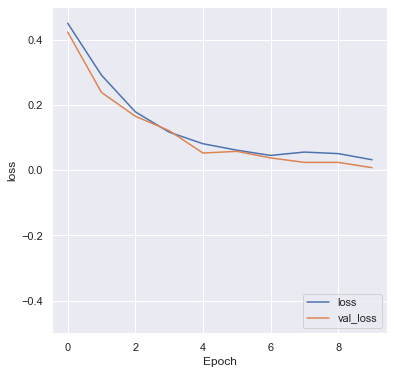

In [111]:
plt.plot(train_two_vgg_drop.history['loss'], label='loss')
plt.plot(train_two_vgg_drop.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.ylim([-0.5, 0.5])
plt.legend(loc='lower right')

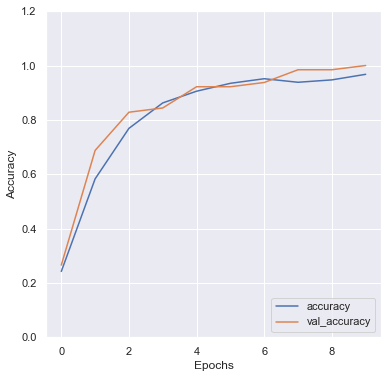

In [112]:
plt.plot(train_two_vgg_drop.history['accuracy'], label='accuracy')
plt.plot(train_two_vgg_drop.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim([0.0, 1.2])
plt.legend(loc='lower right')

Two VGG blocks with Dropout and BatchNormalization

In [113]:
model_two_vgg_drop_batch = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), padding = "same", activation='relu', input_shape = (64, 64, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3, 3), padding = "same", activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(128, (3, 3), padding = "same", activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, (3, 3), padding = "same", activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(6, activation = 'softmax')
])

model_two_vgg_drop_batch.compile(optimizer = "adam",
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

model_two_vgg_drop_batch.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 64, 64, 64)        1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 64)        256       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 64, 64, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 64)        256       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 32, 32, 128)     

In [114]:
startTimeCNN = timer()
train_two_vgg_drop_batch = model_two_vgg_drop_batch.fit(x_train,
                                                        y_train_hot,
                                                        epochs=epochs,
                                                        batch_size=batch_size,
                                                        validation_data=(x_valid, y_valid_hot),
                                                        validation_steps=1)

endTimeCNN = timer()

Epoch 1/10
70/70 [==============================] - 194s 3s/step - loss: 0.1496 - accuracy: 0.8266 - val_loss: 0.5668 - val_accuracy: 0.2500
Epoch 2/10
70/70 [==============================] - 194s 3s/step - loss: 0.0357 - accuracy: 0.9631 - val_loss: 1.6605 - val_accuracy: 0.2500
Epoch 3/10
70/70 [==============================] - 194s 3s/step - loss: 0.0171 - accuracy: 0.9842 - val_loss: 0.5232 - val_accuracy: 0.3281
Epoch 4/10
70/70 [==============================] - 194s 3s/step - loss: 0.0086 - accuracy: 0.9926 - val_loss: 0.8616 - val_accuracy: 0.2031
Epoch 5/10
70/70 [==============================] - 194s 3s/step - loss: 0.0142 - accuracy: 0.9872 - val_loss: 0.4903 - val_accuracy: 0.4062
Epoch 6/10
70/70 [==============================] - 194s 3s/step - loss: 0.0050 - accuracy: 0.9957 - val_loss: 0.4370 - val_accuracy: 0.4219
Epoch 7/10
70/70 [==============================] - 323s 5s/step - loss: 0.0050 - accuracy: 0.9964 - val_loss: 0.4471 - val_accuracy: 0.4531
Epoch 8/10
70

In [115]:
print("Time needed to run the CNN is: {} minutes and {:.1f} seconds".format((endTimeCNN - startTimeCNN)//60, (endTimeCNN - startTimeCNN)%60))

Time needed to run the CNN is: 76.0 minutes and 16.3 seconds


In [116]:
test_two_vgg_drop_batch = model_two_vgg_drop_batch.evaluate(x_test, y_test_hot, verbose=0)  

pred_labels_two_vgg_drop_batch = model_two_vgg_drop_batch.predict_classes(x_test)

In [117]:
y_pred_two_vgg_drop_batch = []
for elem in pred_labels_two_vgg_drop_batch:
    y_pred_two_vgg_drop_batch.append(elem)

In [118]:
df_two_vgg_drop_batch=pd.DataFrame({'Original labels':y_test_orig,
                                    'Predicted labels':y_pred_two_vgg_drop_batch})
df_two_vgg_drop_batch

,Original labels,Predicted labels
0,5,5
1,5,5
2,5,5
3,4,4
4,0,0
...,...,...
1105,0,0
1106,3,3
1107,2,2
1108,2,2


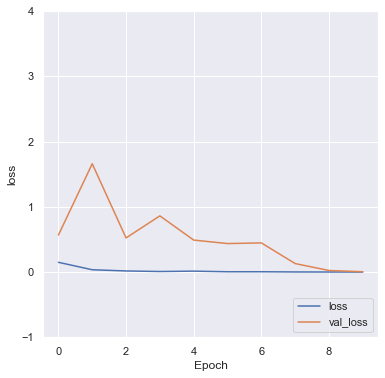

In [119]:
plt.plot(train_two_vgg_drop_batch.history['loss'], label='loss')
plt.plot(train_two_vgg_drop_batch.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.ylim([-1, 4])
plt.legend(loc='lower right')

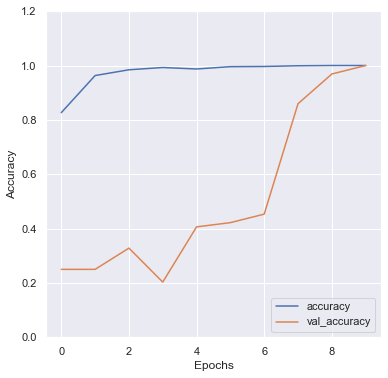

In [120]:
plt.plot(train_two_vgg_drop_batch.history['accuracy'], label='accuracy')
plt.plot(train_two_vgg_drop_batch.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim([0.0, 1.2])
plt.legend(loc='lower right')

2 VGG blocks with adaptive learning rate

In [121]:
model_two_vgg_lr = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), padding = "same", activation='relu', input_shape = (64, 64, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3, 3), padding = "same", activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(128, (3, 3), padding = "same", activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, (3, 3), padding = "same", activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(6, activation = 'softmax')
])

model_two_vgg_lr.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01),
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

model_two_vgg_lr.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 64, 64, 64)        1792      
_________________________________________________________________
batch_normalization_5 (Batch (None, 64, 64, 64)        256       
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 64, 64, 64)        36928     
_________________________________________________________________
batch_normalization_6 (Batch (None, 64, 64, 64)        256       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 32, 32, 128)     

In [122]:
train_two_vgg_lr = model_two_vgg_lr.fit(x_train,
                                  y_train_hot,
                                  epochs=epochs,
                                  batch_size=batch_size,
                                  validation_data=(x_valid, y_valid_hot),
                                  validation_steps=1,
                                  callbacks=[lr_decay_callback])



Epoch 00001: LearningRateScheduler reducing learning rate to 0.01.
Epoch 1/10
70/70 [==============================] - 154s 2s/step - loss: 0.2347 - accuracy: 0.6995 - val_loss: 0.9865 - val_accuracy: 0.3594

Epoch 00002: LearningRateScheduler reducing learning rate to 0.006.
Epoch 2/10
70/70 [==============================] - 134s 2s/step - loss: 0.0466 - accuracy: 0.9491 - val_loss: 0.8640 - val_accuracy: 0.4062

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0036.
Epoch 3/10
70/70 [==============================] - 134s 2s/step - loss: 0.0193 - accuracy: 0.9818 - val_loss: 0.5240 - val_accuracy: 0.4062

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0021599999999999996.
Epoch 4/10
70/70 [==============================] - 134s 2s/step - loss: 0.0099 - accuracy: 0.9921 - val_loss: 0.4934 - val_accuracy: 0.4531

Epoch 00005: LearningRateScheduler reducing learning rate to 0.001296.
Epoch 5/10
70/70 [==============================] - 135s 2s/step - loss:

There is no improvement in adding ad adaptive learning rate: acutally the model performance decreases.

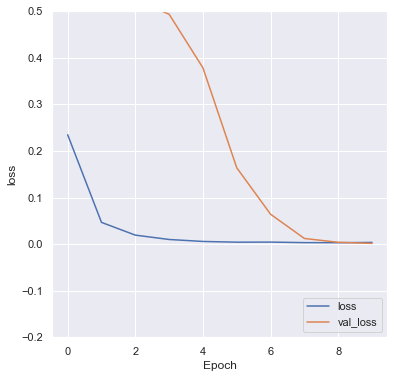

In [123]:
plt.plot(train_two_vgg_lr.history['loss'], label='loss')
plt.plot(train_two_vgg_lr.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.ylim([-0.2, 0.5])
plt.legend(loc='lower right')

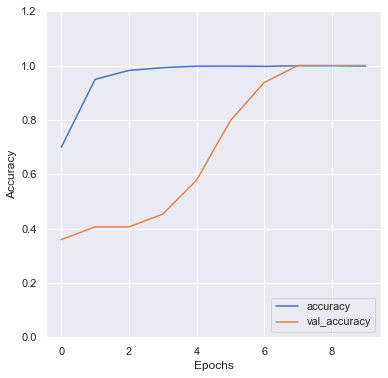

In [124]:
plt.plot(train_two_vgg_lr.history['accuracy'], label='accuracy')
plt.plot(train_two_vgg_lr.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim([0.0, 1.2])
plt.legend(loc='lower right')

Grayscale images

In [125]:
model_gray = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), padding = "same", activation='relu', input_shape = (64, 64, 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3, 3), padding = "same", activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(128, (3, 3), padding = "same", activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, (3, 3), padding = "same", activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(6, activation = 'softmax')
])

model_gray.compile(optimizer = "adam",
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

model_gray.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 64, 64, 64)        640       
_________________________________________________________________
batch_normalization_10 (Batc (None, 64, 64, 64)        256       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 64, 64, 64)        36928     
_________________________________________________________________
batch_normalization_11 (Batc (None, 64, 64, 64)        256       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 32, 32, 128)     

In [126]:
train_gray = model_gray.fit(x_train_gray, y_train_hot,
                                    epochs=epochs,
                                    batch_size=batch_size,
                                    validation_data=(x_valid_gray, y_valid_hot))

test_gray = model_gray.evaluate(x_test_gray, y_test_hot, verbose=0)  

pred_labels_gray = model_gray.predict_classes(x_test_gray)

Epoch 1/10
444/444 [==============================] - 143s 322ms/step - loss: 0.4306 - accuracy: 0.3836 - val_loss: 0.4247 - val_accuracy: 0.3267
Epoch 2/10
444/444 [==============================] - 147s 332ms/step - loss: 0.3490 - accuracy: 0.5151 - val_loss: 0.3019 - val_accuracy: 0.5778
Epoch 3/10
444/444 [==============================] - 153s 343ms/step - loss: 0.2643 - accuracy: 0.6527 - val_loss: 0.2287 - val_accuracy: 0.7022
Epoch 4/10
444/444 [==============================] - 152s 342ms/step - loss: 0.1968 - accuracy: 0.7599 - val_loss: 0.2112 - val_accuracy: 0.7133
Epoch 5/10
444/444 [==============================] - 153s 345ms/step - loss: 0.1592 - accuracy: 0.8113 - val_loss: 0.1643 - val_accuracy: 0.7978
Epoch 6/10
444/444 [==============================] - 154s 347ms/step - loss: 0.1144 - accuracy: 0.8646 - val_loss: 0.2870 - val_accuracy: 0.6933
Epoch 7/10
444/444 [==============================] - 153s 345ms/step - loss: 0.0913 - accuracy: 0.8982 - val_loss: 0.1489 -

In [127]:
y_pred_gray = []
for elem in pred_labels_gray:
    y_pred_gray.append(elem)

In [128]:
df_gray=pd.DataFrame({'Original labels':y_test_orig,
                      'Predicted labels':y_pred_gray})
df_gray

,Original labels,Predicted labels
0,5,5
1,5,5
2,5,0
3,4,4
4,0,0
...,...,...
1105,0,0
1106,3,3
1107,2,2
1108,2,2


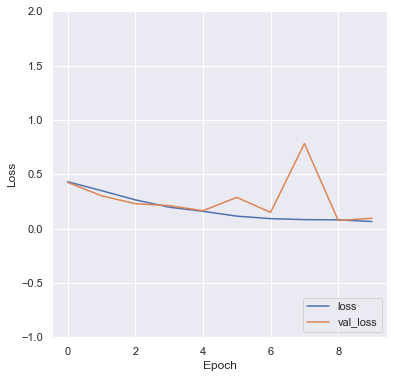

In [130]:
plt.plot(train_gray.history['loss'], label='loss')
plt.plot(train_gray.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([-1, 2])
plt.legend(loc='lower right')

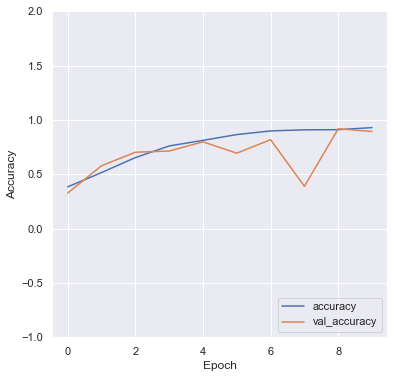

In [129]:
plt.plot(train_gray.history['accuracy'], label='accuracy')
plt.plot(train_gray.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([-1, 2])
plt.legend(loc='lower right')

# PCA

In [132]:
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

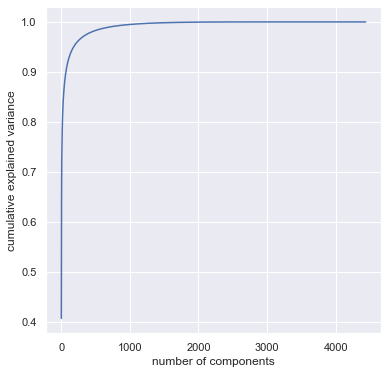

In [191]:
startTime_PCA = timer()

x_pca=PCA().fit(x_train_flat)
plt.plot(np.cumsum(x_pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

endTime_PCA = timer()

In [186]:
print("Time to convert the features is: {} minutes and {:.1f} seconds".format((endTime_PCA - startTime_PCA)//60, (endTime_PCA - startTime_PCA)%60))

Time to convert the features is: 1.0 minutes and 6.7 seconds


In [134]:
pca_rgb = PCA(0.9)

In [135]:
train_rgb = pca_rgb.fit(x_train_flat)
valid_rgb = pca_rgb.fit(x_valid_flat)
test_rgb = pca_rgb.fit(x_test_flat)

In [136]:
pca_rgb.n_components_

58

In [137]:
train_pca = pca_rgb.transform(x_train_flat)
valid_pca = pca_rgb.transform(x_valid_flat)
test_pca = pca_rgb.transform(x_test_flat)

In [172]:
train_pca.shape, valida_pca

(4440, 58)

# Feed-Forward NN on PCA components

Feed-Forward NN for PCA

In [177]:
model_pca = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(pca_rgb.n_components_,)),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(6, activation='softmax')
])

model_pca.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# print model layers
model_pca.summary()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_24 (Flatten)         (None, 58)                0         
_________________________________________________________________
dense_64 (Dense)             (None, 100)               5900      
_________________________________________________________________
dropout_54 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_65 (Dense)             (None, 64)                6464      
_________________________________________________________________
dropout_55 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_66 (Dense)             (None, 6)                 390       
Total params: 12,754
Trainable params: 12,754
Non-trainable params: 0
_________________________________________________

In [178]:
startTime_pca = timer()
history_pca = model_pca.fit(train_pca,
                            y_train_hot,
                            batch_size=batch_size,
                            epochs=30,
                            validation_data=(valid_pca, y_valid_hot),
                            validation_steps=1)

endTime_pca = timer()

Epoch 1/30
70/70 [==============================] - 0s 3ms/step - loss: 0.4488 - accuracy: 0.2158 - val_loss: 0.4457 - val_accuracy: 0.2969
Epoch 2/30
70/70 [==============================] - 0s 2ms/step - loss: 0.4377 - accuracy: 0.3171 - val_loss: 0.4296 - val_accuracy: 0.2969
Epoch 3/30
70/70 [==============================] - 0s 2ms/step - loss: 0.4150 - accuracy: 0.3698 - val_loss: 0.4057 - val_accuracy: 0.3750
Epoch 4/30
70/70 [==============================] - 0s 2ms/step - loss: 0.3867 - accuracy: 0.4318 - val_loss: 0.3775 - val_accuracy: 0.4531
Epoch 5/30
70/70 [==============================] - 0s 2ms/step - loss: 0.3515 - accuracy: 0.5153 - val_loss: 0.3404 - val_accuracy: 0.5469
Epoch 6/30
70/70 [==============================] - 0s 2ms/step - loss: 0.3188 - accuracy: 0.5818 - val_loss: 0.3079 - val_accuracy: 0.6094
Epoch 7/30
70/70 [==============================] - 0s 2ms/step - loss: 0.2895 - accuracy: 0.6288 - val_loss: 0.2815 - val_accuracy: 0.6250
Epoch 8/30
70/70 [==

In [179]:
print("Time needed to perform the CNN on the 1st PCA model is: {} minutes and {:.1f} seconds".format((endTime_pca - startTime_pca)//60, (endTime_pca - startTime_pca)%60))

Time needed to perform the CNN on the 1st PCA model is: 0.0 minutes and 5.4 seconds


In [180]:
history_test_pca = model_pca.evaluate(test_pca, y_test_hot, verbose=0)  

pred_labels_pca = model_pca.predict_classes(test_pca)

In [181]:
y_pred_pca = []
for elem in pred_labels_pca:
    y_pred_pca.append(elem)

In [182]:
df_pca=pd.DataFrame({'Original labels':y_test_orig,
                     'Predicted labels':y_pred_pca})
df_pca

,Original labels,Predicted labels
0,5,5
1,5,5
2,5,5
3,4,4
4,0,0
...,...,...
1105,0,0
1106,3,3
1107,2,2
1108,2,2


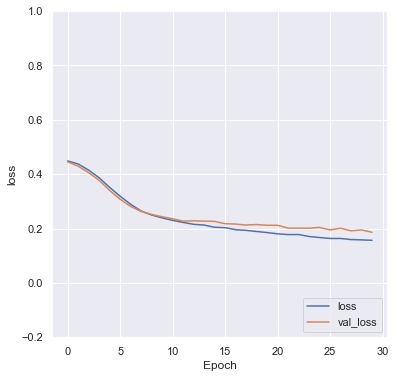

In [183]:
plt.plot(history_pca.history['loss'], label='loss')
plt.plot(history_pca.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.ylim([-0.2, 1])
plt.legend(loc='lower right')

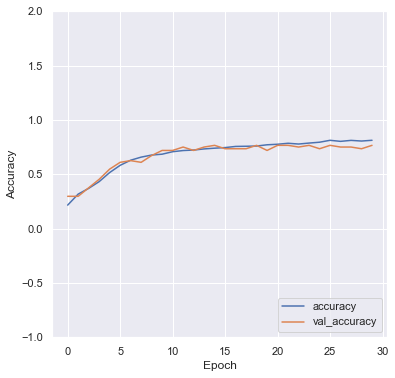

In [184]:
plt.plot(history_pca.history['accuracy'], label='accuracy')
plt.plot(history_pca.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([-1, 2])
plt.legend(loc='lower right')